# Dynamic information encoding by neural networks

In this project, we're going to look at real neuron data from a region of the prefrontal cortex (dACC) that is tuned to the value of objects. We shall use correlations and PCA to visualise the exact temporal dynamics of how it encodes these values.

#### Data import

Our x data consists of the value of the image on each trial and our y data is the pre-processed normalised firing rate of neurons within the anterior cingulate cortex for 0-1500 ms after the cue was shown. 

In [1]:
import numpy as np
import scipy
import plot  # Custom plot function for this script
import matplotlib.pyplot as plt
import maths
import sklearn.decomposition
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D

x = np.load('x.npy')[0] # The value of the cue [numFeatures x numSamples]
y = np.load('y.npy')  # The firing rates of our neurons over time [numFeatures x numSamples x numTimepoints]

# Data parameters
time = range(0, 1800, 10)  # Data is in 10 ms steps
numNeurons, numSamples, numTimepoints = y.shape
numValues = 5  # There were 5 different values in total

Lets first look at what a few the neurons do in response to the five different cue values. We'll bin trials into each cue value and compute the average and SEM of the firing rates.

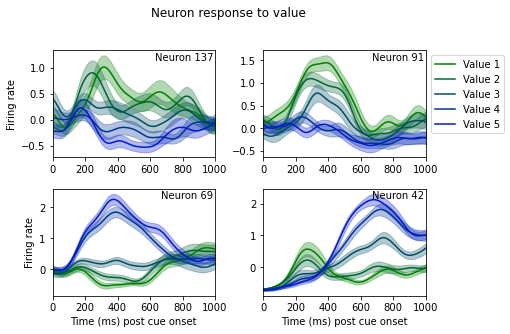

In [2]:
averages,sems = np.empty((numNeurons,numValues,numTimepoints)),np.empty((numNeurons,numValues,numTimepoints))

for i, (yy, xx) in enumerate(zip(y, x)):
        
    # Calculate mean and SEM for response to each value
    averages[i] = [np.mean(yy[xx==val], axis=0) for val in np.unique(xx)]
    sems[i] = [np.std(yy[xx==val], axis=0) / np.sqrt(len(yy[xx==val])) for val in np.unique(xx)]

plot.plot1(averages, sems);

Cool, we can see our neurons are really sensitive to value. But they are also very diverse in how they encode value. Some increase their firing rates for high value (bottom row) and some for low values (top row). The time course of each response also differs, both in latency and duration.  

Let's now use linear regression to model each neuron's response to value at each time point. I've already covered this in another [project](https://github.com/jamesbutler01/Portfolio/blob/main/Simultaneous%20value%20coding/NeuronValueCoding.ipynb), so we'll use the custom functions from there.

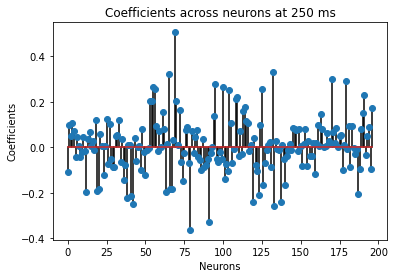

In [3]:
coeffs = np.empty((numNeurons, numTimepoints))

for i, (yy, xx) in enumerate(zip(y, x)):  # For each neuron
        
    # Fit model and log coefficients
    coeffs[i] = maths.reg(xx, yy)[1]

plot.plot2(coeffs)

Great, we can see a real heterogeneous mix of coefficients across our neural population, and this is just one timepoint!

#### Correlation matrices

Lets now examine how the network encoding of value changes over time. To do this we'll compute a correlation matrix to examine how similar the value response is at each time point. Because time is autocorrelated and will confound our analysis, we'll split our data into two random halves and fit our model on each seperately. The correlation of coefficients between these two halves is then free of any confounds.

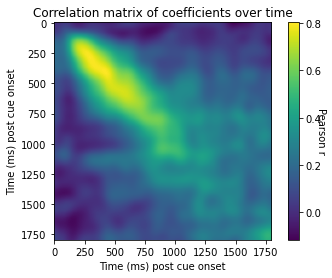

In [4]:
coeffs = np.empty((2, numNeurons, numTimepoints))
for i, (yy, xx) in enumerate(zip(y, x)):
        
    # Random 50:50 split
    randInds = np.random.permutation(numSamples)
    firstsplit,secondsplit = randInds[::2],randInds[1::2]

    # Fit model and log coefficients
    coeffs[0, i] = maths.reg(xx[firstsplit], yy[firstsplit])[1]
    coeffs[1, i] = maths.reg(xx[secondsplit], yy[secondsplit])[1]

# Correlate our coefficients over time
corrMatrix = np.corrcoef(coeffs[0].T, coeffs[1].T)
corrMatrix = corrMatrix[numTimepoints:,:numTimepoints]  # Just want quarter of the corrMatrix

plot.plot3(corrMatrix)

Overall our r-values are high, which indicates the neurons were responding consistently on each trial. Lets use Scipy's pearson function to calculate p-values and only display the significant portions of our correlation matrix.

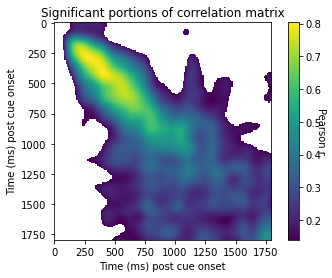

In [5]:

def calcSigCorrMatrix(coeffs):
    # Time by time point correlation to get each p-value
    rs, ps = np.empty([numTimepoints]*2),np.empty([numTimepoints]*2)
    for i in range(numTimepoints):
        for j in range(numTimepoints):
            rs[i,j],ps[i,j] = scipy.stats.pearsonr(coeffs[0,:,i],coeffs[1,:,j])

    # NaN any points where p>0.05
    rs[ps>0.05] = np.nan
    
    return rs, ps

sigCorrMatrix, pvalues = calcSigCorrMatrix(coeffs)

plot.plot3(sigCorrMatrix, 1)

Cool, we can see that the correlations are focused around the diagonal of the matrix and the off diagonal components are mostly uncorrelated. Therefore, the neural network's encoding is dynamic - the way in which it represents information constantly changes over time.

#### The neural network can rotate its encoding

An additional part of the task is that a second cue was actually shown ~800 ms after the first cue. This cue either added or subtracted to the value of the first cue and thus affected how the stored value of the first cue should be handled. So far we've been averaging over this effect by examining all trials. Let's now split trials by this condition and examine the correlation over time between the conditions.

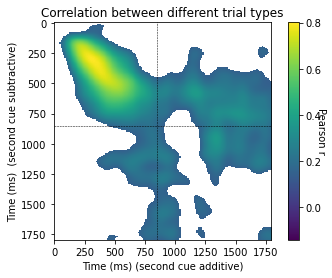

In [6]:
# Load whether the second cue added or subtracted from the first cue
trialtype = np.load('x.npy')[1]

coeffs = np.empty((2, numNeurons, numTimepoints))
for i, (yy, xx, t) in enumerate(zip(y, x, trialtype)):

    # Fit model seperately for each trial type and store coefficients
    coeffs[0, i] = maths.reg(xx[t==0], yy[t==0])[1]
    coeffs[1, i] = maths.reg(xx[t==1], yy[t==1])[1]

    
corrMatrix, pvalues = calcSigCorrMatrix(coeffs)

plot.plot3(corrMatrix,2)

Strikingly, after the second cue was shown (black dashed line) the network's encoding of the first cue's value diverged between the two trial types. Let's look at the time point where this happens in a bit more detail.

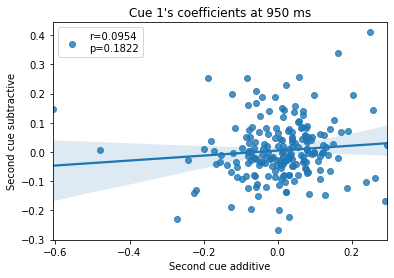

In [7]:
tp = 95  # 950 ms after cue 1 (~150 ms after cue 2)
r, p = scipy.stats.pearsonr(coeffs[0,:,tp],coeffs[1,:,tp])

# Plot
sb.regplot(coeffs[0,:,tp], coeffs[1,:,tp], label=f'r={np.round(r, 4)}\np={np.round(p, 4)}')
plt.xlabel('Second cue additive'), plt.ylabel('Second cue subtractive'); plt.legend()
plt.title(f'Cue 1\'s coefficients at {tp*10} ms');

We can see that shortly after the second cue was shown, the coefficients for cue 1 are no longer correlated with one another. Instead they are now  orthogonal to one another. This means that the neural network had the ability to store two distinct representations of cue 1 depending on the type of information that it saw immediately afterwards! This would be very useful for performing computations by having a buffer capable of storing different pieces of information with orthogonal coding schemes.   

#### Principal component analysis

Principal component analysis (PCA) is a powerful tool that allows us to transform high dimensional data into lower dimensional subspaces. Let's use PCA to visualise the network rotating its stored information into these two orthogonal coding schemes. 

The input to the PCA will be the neural firing rates in response to each of the five values in our two conditions (so 10 features in total). Lets get those values now.

In [8]:
avgs = np.empty((10, numNeurons, numTimepoints))

# Loop through each cell's data
for i, (yy, xx, t) in enumerate(zip(y, x, trialtype)):
        
    # Calculate average response to each value for first trial type
    avgs[:5, i] = [np.mean(yy[(xx==val) & (t==0)], axis=0) for val in np.unique(xx)]

    # Same again for second trial type
    avgs[5:, i] = [np.mean(yy[(xx==val) & (t==1)], axis=0) for val in np.unique(xx)]

Now PCA only works in 2 dimensions, but we currently have 3 dimensions ([values x neurons x time]). So we'll average the time dimension over our point of interest to create a matrix with dimensions [values x neurons]. Then we can perform PCA on this matrix.

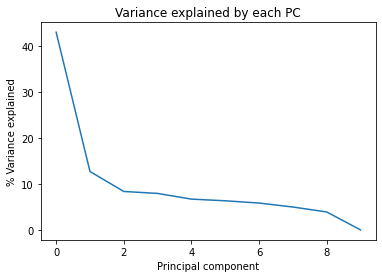

In [9]:
# Average over time dimension
valuesByNeurons = np.mean(avgs[:, :, 50:80],axis=-1)

# Do PCA
pca = sklearn.decomposition.PCA()
model = pca.fit(valuesByNeurons)

#Plot
plt.plot( model.explained_variance_ratio_*100); plt.title('Variance explained by each PC');
plt.xlabel('Principal component');plt.ylabel('% Variance explained');

As is typical with biological data, the majority of the variance in our neuron firing rates is explained by the first couple of  principal components (PCs). 

We can now project our original timecourse data back onto a low dimensional subspace defined by the first two PCs. This will enable us to visualise how the network's encoding of value rotates depending on the type of second cue shown.

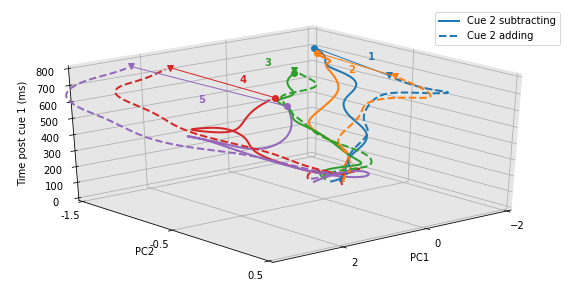

In [10]:
dotProducts = np.empty((10, 2, numTimepoints))

for i in range(10):  # For each value in each condition
    
    # Take the dot product of our model's weights with the neuron firing rates
    dotProducts[i, :] = [np.dot(model.components_[ii], avgs[i]) for ii in range(2)]

plot.plot4(dotProducts)

Cool, we can see how initially the trajectories for each value in the two conditions are near to one another. Then, when the second cue is shown, the trajectories rapidly diverge between the two conditions. 

Let's look at two time points more closely to better visualise the effect. 

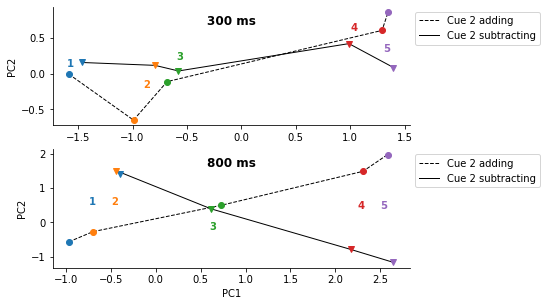

In [12]:
# Take timepoint before and after second cue occurred
timepoint1 = 30; timepoint2 = 80
timepoints = dotProducts[..., [timepoint1, timepoint2]]

plot.plot5(timepoints)

Both before and after the second cue is shown, we can see that PC1 encodes the value of the cue. This is true for both conditions (solid and dashed lines).

After the second cue has been shown, however, PC2 now encodes opposite values depending on what type of second cue was shown! A downstream region can therefore readout from the first PC if it want's to know the value of the first cue, or from the second PC if it wants to know how the value of the first cue relates to the second cue. 

This is a novel demonstration of how the ACC neural network is able to dynamically alter its stored value representations depending on what we want to use the information for.